Cluster molecules and prioritize series from a high throughput screen.

Structure/activity data drawn from "A High Throughput Confirmatory Assay used to Identify Novel Compounds that Inhibit Mycobacterium Tuberculosis in the absence of Glycerol" (PubChem AID 449764).
https://pubchem.ncbi.nlm.nih.gov/bioassay/449764

Molecular descriptors calculated with KNIME-CDK version 1.5.600.v201711101057.

In [1]:
## setup cell
# chemistry libaries
from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit import DataStructs

# scikit-learn functions
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# general purpose libraries
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# display interactive plots in notebook
%matplotlib notebook

In [3]:
## load and process data
# load the initial dataset
screening_data = pd.read_csv("data/descriptors.csv")

# generate pIC90 for plotting; add placeholder value of 1 for inactive compounds
screening_data["pIC90"] = screening_data["IC90"].apply(lambda x: -1 * np.log10(x * 1e-6))
screening_data["pIC90"][screening_data["IC90"].isna()] = 1

# bin pIC90 for plotting
screening_data["activity levels"] = pd.cut(screening_data["pIC90"], bins = [0, 2, 4, 5, 100], labels = ["inactive", "low", "medium", "high"])

# generate pIC50 for plotting; add placeholder value of 1 for inactive compounds
screening_data["pIC50"] = screening_data["IC50"].apply(lambda x: -1 * np.log10(x * 1e-6))
screening_data["pIC50"][screening_data["IC50"].isna()] = 1

# bin pIC50 for plotting
screening_data["cytotoxicity"] = pd.cut(screening_data["pIC50"], bins = [0, 2, 4, 5, 100], labels = ["inactive", "low", "medium", "high"])

# convert SMILES strings into RDKit format
screening_data["mol"] = screening_data["SMILES"].apply(Chem.MolFromSmiles)

# calculate Morgan fingerprints for the molecules
screening_data["fingerprints"] = screening_data["mol"].apply(lambda x: GetMorganFingerprintAsBitVect(x, 2))

In [4]:
## calculate Tanimoto distance matrix between molecular fingerprints
# declare an array to hold the distances
distances = np.empty([len(screening_data["fingerprints"]), len(screening_data["fingerprints"])])

# calculate the distance array
for i in range(len(screening_data["fingerprints"])):
    for j in range(i, len(screening_data["fingerprints"])):
        distances[i, j] = 1 - DataStructs.TanimotoSimilarity(screening_data["fingerprints"][i], screening_data["fingerprints"][j])
        distances[j, i] = distances[i, j]

<IPython.core.display.Javascript object>


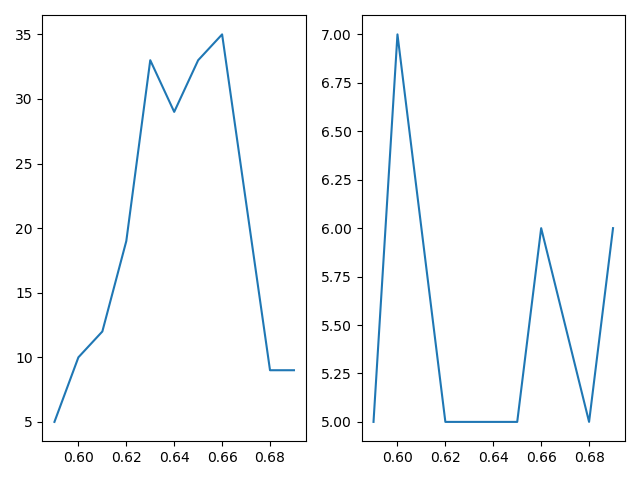

In [5]:
## tune clustering algorithm
# select some values of epsilon to try
epsilon = np.arange(0.59, 0.7, 0.01)

# declare an empty array to hold the number of clusters
n_clusters = np.empty([len(epsilon), 2])

# scan through epsilon values
for i in range(len(epsilon)):
    # cluster by distance at each epsilon
    clusters = DBSCAN(eps = epsilon[i], min_samples = 5, metric = "precomputed").fit(distances)
    
    # store the number of clusters generated and median cluster size
    # number of clusters (including singletons as a class)
    n_clusters[i, 0] = len(np.unique(clusters.labels_))
    # median cluster size
    n_clusters[i, 1] = np.median(pd.Series(clusters.labels_).value_counts())
    
# plot number of clusters as a function of epsilon
fig, axs = plt.subplots(1, 2, tight_layout = True)
axs[0].plot(epsilon, n_clusters[:, 0])
axs[1].plot(epsilon, n_clusters[:, 1])
plt.show()

In [6]:
## cluster compounds
# cluster compounds to give a balance between number of clusters and cluster size; store in dataframe
screening_data["cluster"] = DBSCAN(eps = 0.61, min_samples = 5, metric = "precomputed").fit(distances).labels_

# count the number of compounds per cluster
screening_data.cluster.value_counts()

-1     2176
 3       14
 5       12
 4       10
 2        9
 1        7
 9        5
 7        5
 10       5
 6        5
 0        5
 8        4
Name: cluster, dtype: int64

We have a large number of singletons in the dataset, but we have identified 11 clusters of reasonable size. The next step will be to evaluate the clustered compounds, plus look for singletons with particularly interesting chemical properties.

<IPython.core.display.Javascript object>


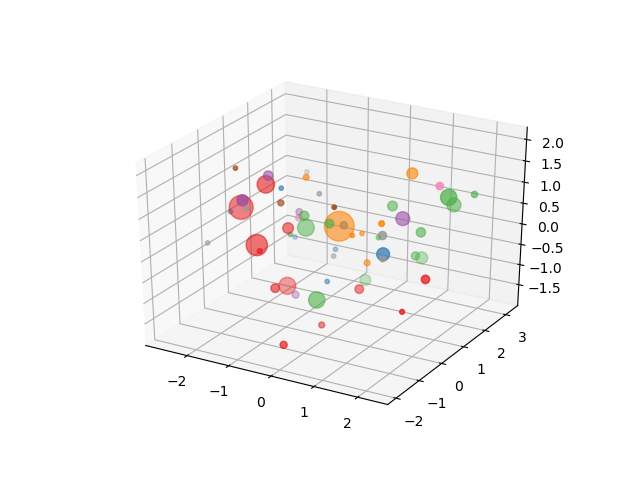

In [14]:
### visualize the clustering
## calculate principle components from the available molecular descriptors
# select descriptors from the dataframe
descriptors = screening_data[['Aromatic Atoms Count', 'Bond Polarizabilities', 'VABC Volume Descriptor', 
       'Hydrogen Bond Acceptors', 'Hydrogen Bond Donors', 'Rotatable Bonds Count', 'Topological Polar Surface Area',
       'Molecular Weight', 'XLogP', 'SP3 Character']]

# standardize features
descriptors = StandardScaler().fit_transform(descriptors.values)

# calculate first three principle components of descriptors; store back in dataframe
pca = PCA(n_components = 3)
screening_data[["pca1", "pca2", "pca3"]] = pd.DataFrame(pca.fit_transform(descriptors))

## plot the clustered compounds
# subset the series from the larger dataset
clustered_data = screening_data.query("cluster != -1")

# plot
# size by antitubercular activity
# color by cluster
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = "3d")

ax.scatter(clustered_data["pca1"], clustered_data["pca2"], clustered_data["pca3"],
           s = clustered_data["IC90"] ** -1 * 1e3, c = clustered_data["cluster"], cmap = "Set1")
plt.show()

Neither the activity nor the clusters show a clear pattern in the featurespace. This is not particularly surprising given that this is a phenotypic screen; however, it is good to check.

<IPython.core.display.Javascript object>


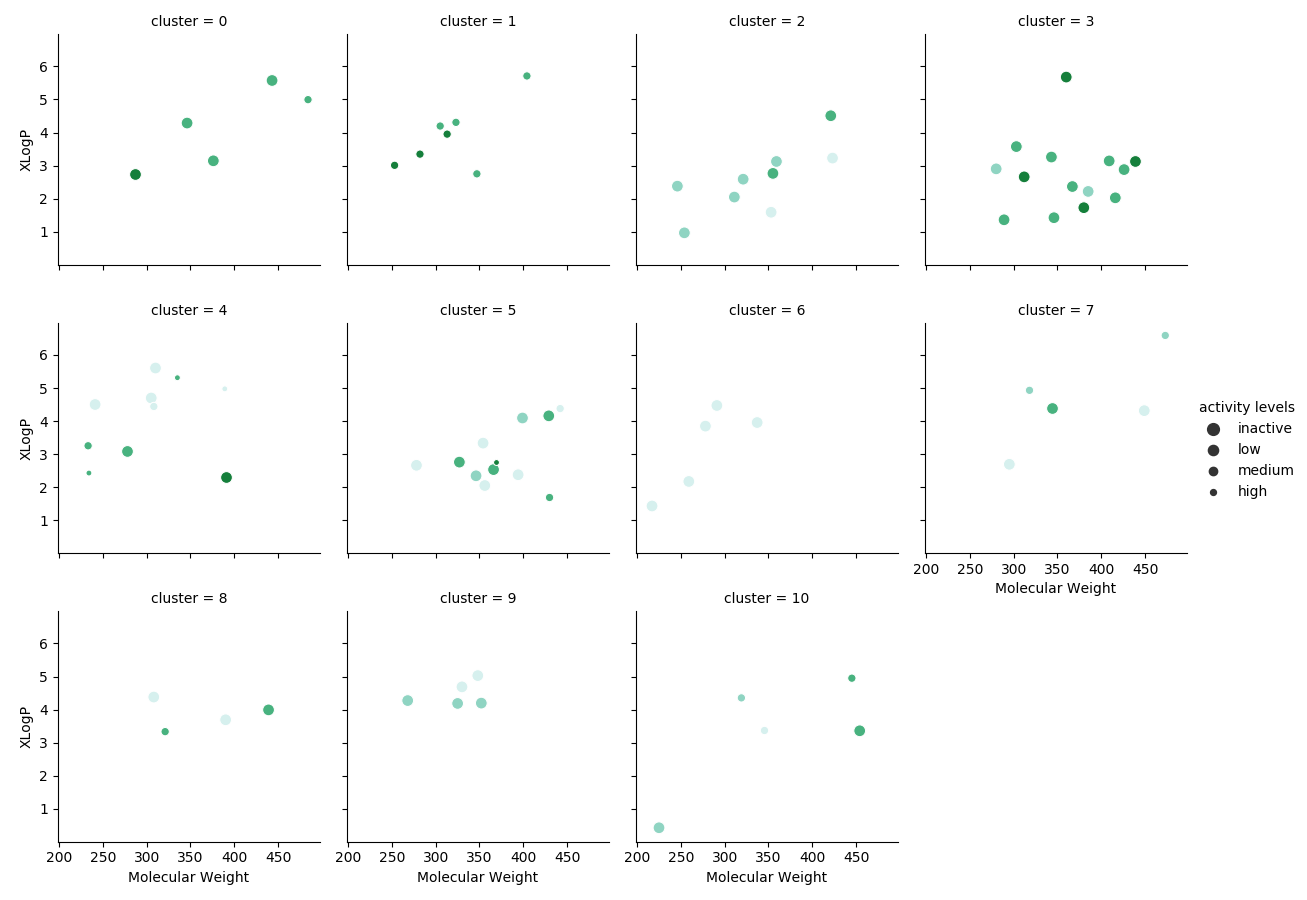

In [35]:
## plot clusters independently
# plot the clusters
ax = sns.FacetGrid(clustered_data, col = "cluster", hue = "activity levels", palette = "BuGn", col_wrap = 4)
ax = ax.map(sns.scatterplot, "Molecular Weight", "XLogP", size = clustered_data.cytotoxicity).add_legend()

The most exciting clusters here are 0, 1, and 3.

Clusters 2, 4, and 5 are next.

Clusters 7, 8, 9, 10 are low priority.

Cluster 6 appears completely dead.


Looking at the singletons:

<IPython.core.display.Javascript object>


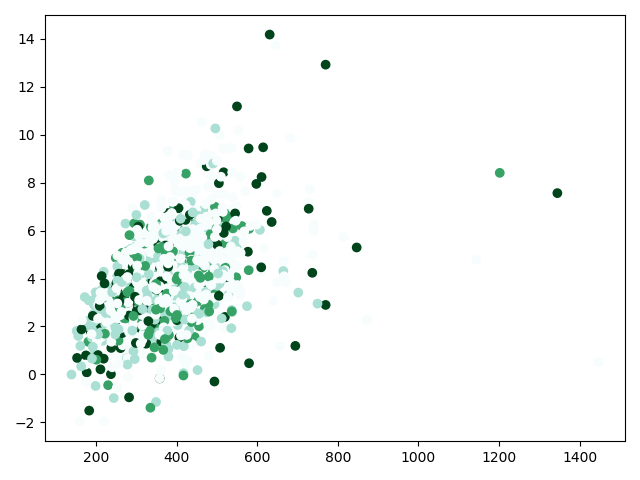

In [9]:
## plot singletons to look for particularly appealing compounds
# subset the series from the larger dataset
singletons = screening_data.query("cluster == -1")

# plot the singletons
fig, ax = plt.subplots(1, 1, tight_layout = True)
ax.scatter(singletons["Molecular Weight"], singletons["XLogP"], c = singletons["activity levels"].factorize()[0], cmap = "BuGn")
fig.show()

In [10]:
# pull out the particularly interesting singletons
# MW < 300, logP < 2, IC90 < 5 µMb
singletons[singletons["Molecular Weight"] < 300][singletons["XLogP"] < 2][singletons["pIC90"] > 5.5]

,row ID,SMILES,Mtb Activity,IC90 Modifier,IC90,Vero Activity,IC50 Modifier,IC50,Aromatic Atoms Count,Bond Polarizabilities,...,Formal Charge,SP3 Character,pIC90,activity levels,mol,fingerprints,cluster,pca1,pca2,pca3
712,17409303,C/C(=C\C1=NC2=CC=CC=C2OC1=O)/O,Active,NaN,0.89,Inactive,NaN,NaN,10,14.032863,...,0,0.041667,6.050610,high,<rdkit.Chem.rdchem.Mol object at 0x000001E6FA2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-3.364881,1.051157,0.261063
1049,24779081,CC1=C(N=C(NC1=O)SCC(=O)NC2CCCCC2)C,Active,NaN,0.57,Inactive,NaN,NaN,6,29.793347,...,0,0.219512,6.244125,high,<rdkit.Chem.rdchem.Mol object at 0x000001E6FA2...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-0.489074,2.166288,-1.611655
1402,24827565,CN(CC1=CC=C(S1)Cl)C(=O)CCl,Active,NaN,1.73,Active,NaN,11.721,5,15.896863,...,0,0.136364,5.761954,high,<rdkit.Chem.rdchem.Mol object at 0x000001E6FA2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-3.020392,1.414221,-1.664811
1786,49666263,C1=CC=C(C=C1)S(=O)(=O)C2=NC=C(C=C2)[N+](=O)[O-],Active,NaN,2.98,Active,NaN,8.089,12,17.797656,...,0,0.000000,5.525784,high,<rdkit.Chem.rdchem.Mol object at 0x000001E6FA2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-2.626949,0.952146,1.026712
